# Exploratory Data Analysis  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import scatter_matrix
import seaborn as sns
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import coint
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import ccf
from statsmodels.tsa.vector_ar.var_model import VAR


/Users/Welliareetil/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
pathA = '/Users/Welliareetil/Documents/Cabestan-technical challenge/WelliaveetilDataset/A.csv'
pathB = '/Users/Welliareetil/Documents/Cabestan-technical challenge/WelliaveetilDataset/B.csv'
pathC = '/Users/Welliareetil/Documents/Cabestan-technical challenge/WelliaveetilDataset/C.csv'
pathD = '/Users/Welliareetil/Documents/Cabestan-technical challenge/WelliaveetilDataset/D.csv'

In [3]:
A = pd.read_csv(pathA)
B = pd.read_csv(pathB)
C = pd.read_csv(pathC)
D = pd.read_csv(pathD)

In [4]:
A.columns = ["date",'op_A', 'hi_A', 'lo_A', 'se_A', 'volume_A', 'oi_A']
B.columns = ["date",'op_B', 'hi_B', 'lo_B', 'se_B', 'volume_B', 'oi_B']
C.columns = ["date",'op_C', 'hi_C', 'lo_C', 'se_C', 'volume_C', 'oi_C']
D.columns = ["date",'op_D', 'hi_D', 'lo_D', 'se_D', 'volume_D', 'oi_D']

In [5]:
A["date"] = pd.to_datetime(A["date"])
B["date"] = pd.to_datetime(B["date"])
C["date"] = pd.to_datetime(C["date"])
D["date"] = pd.to_datetime(D["date"])

In [6]:
#We make note of the start and end dates of the 4 time series. This will be useful when making plot comparisons. 

a_start = A['date'][0]
a_end = A['date'][len(A['date'])-1]
b_start = B['date'][0]
b_end = B['date'][len(B["date"])-1]
c_start = C['date'][0]
c_end = C['date'][6823]
d_start = D['date'][0]
d_end = D['date'][10025]

In [7]:
A.index = A["date"]
#del(A['date'])
B.index = B["date"]
#del(B['date'])
C.index = C['date']
#del(C['date'])
D.index = D['date']
#del(D['date'])


In [8]:
#We add a column "closing price" to a given dataframe. We feel this is a more natural variable to predict.

def closing_price_column(df,op,s):
    l = pd.Series([df[op][j+1] for j in range(len(df)-1)] + [0])
    df = df.assign(cl = l.values)
    df = df.drop(df.index[-1])
    df.rename(columns = {'cl':s},inplace = True)
    return(df)

In [9]:
A = closing_price_column(A,"op_A","cl_A")
B = closing_price_column(B,"op_B","cl_B")
C = closing_price_column(C,"op_C","cl_C")
D = closing_price_column(D,"op_D","cl_D")

# Missing Values and dates

Checking for missing values and any unusual behaviour. 

In [10]:
null_list = []
null_list.append(list(A.isnull().sum()))
null_list.append(list(B.isnull().sum()))
null_list.append(list(C.isnull().sum()))
null_list.append(list(D.isnull().sum()))
null_list

[[0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 6, 6, 6, 0, 8, 11, 6]]

We see that the series D has some missing values. 

We check if the data has certain dates missing. We do so by counting 
the number of days between the start and end dates of 
the different series and then multiplying this by (251/365) since 251 is a rough estimate of the number of
working days per year. We then subtract the length of the various series which we assume
counts the actual working days 
of the year and then normalize the error by dividing by the number of days between the start and end date. We see that 
this error rate is pretty much constant over all series.

In [11]:
def missing_days(A):
    a_start = A['date'][0]
    a_end = A['date'][len(A['date'])-1]
    deltaA = a_end - a_start
    e1 = deltaA.days*(251/365) - len(A)
    print(e1/deltaA.days)

In [12]:
missing_days(A)

-0.00126714871200338


In [13]:
missing_days(B)

-0.0020423488910734306


In [14]:
missing_days(C)

-0.001242337397924194


In [15]:
missing_days(D)

-0.00237557329068854


# Relationship between the opening prices of the 4 assets

In [16]:
a = max(a_start,b_start,c_start,d_start)
b = min(a_end,b_end,c_end,d_end)

In [17]:
b = '2017/08/29'
a = "1990/07/17"

In [18]:
#A.set_index("date")
#B.set_index("date")
#C.set_index('date')
#D.set_index('date')
#a_start = A['date'][0]
#a_end = A['date'][len(A['date'])-1]
#b_start = B['date'][0]
#b_end = B['date'][len(B["date"])-1]
#c_start = C['date'][0]
#c_end = C['date'][6823]
#d_start = D['date'][0]
#d_end = D['date'][10025]

In [19]:
a = max(a_start,b_start,c_start,d_start)
b = min(a_end,b_end,c_end,d_end)

A comparison plot of the opening prices of A,B,C and D during the relevant time periods. 

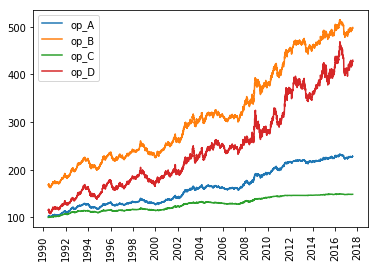

In [20]:
fig,ax = plt.subplots()
ax.plot(A["date"][a:b],A[a:b]['op_A'])
ax.plot(B["date"][a:b],B[a:b]['op_B'])
ax.plot(C["date"],C['op_C'])
ax.plot(D["date"][3135:9964],D[3135:9964]['op_D'])
ax.xaxis.set_major_locator(mdates.YearLocator(2,month = 2,day = 2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.legend()
_=plt.xticks(rotation=90) 
plt.show()

We observe a very strong relationship between the series op_B and op_D. To be sure we calculate correlations between the returns (or in this case day to day changes) between the series. 

In [21]:
A_ret = A.copy()
del(A_ret['date'])
A_ret = A_ret.pct_change()
A_ret = A_ret.dropna(axis = 0)

B_ret = B.copy()
del(B_ret['date'])
B_ret = B_ret.pct_change()
B_ret = B_ret.dropna(axis = 0)

C_ret = C.copy()
del(C_ret['date'])
C_ret = C_ret.pct_change()
C_ret = C_ret.dropna(axis = 0)

D_ret = D.copy()
del(D_ret['date'])
D_ret = D_ret.pct_change()
D_ret = D_ret.dropna(axis = 0)


We create a database that includes all the data from the 4 series A,B,C and D. We study the correlations between series. 

In [22]:
returns = A_ret.join(B_ret,how = 'inner')
returns = returns.join(C_ret,how = "inner")
returns = returns.join(D_ret,how = 'inner')

In [23]:
l = []
for j in list(returns.columns):
    j = j + '_ret'    
    l.append(j)
returns.columns = l    

In [24]:
returns.columns

Index(['op_A_ret', 'hi_A_ret', 'lo_A_ret', 'se_A_ret', 'volume_A_ret',
       'oi_A_ret', 'cl_A_ret', 'op_B_ret', 'hi_B_ret', 'lo_B_ret', 'se_B_ret',
       'volume_B_ret', 'oi_B_ret', 'cl_B_ret', 'op_C_ret', 'hi_C_ret',
       'lo_C_ret', 'se_C_ret', 'volume_C_ret', 'oi_C_ret', 'cl_C_ret',
       'op_D_ret', 'hi_D_ret', 'lo_D_ret', 'se_D_ret', 'volume_D_ret',
       'oi_D_ret', 'cl_D_ret'],
      dtype='object')

In [25]:
correlations_op = returns[['op_A_ret','op_B_ret','op_C_ret','op_D_ret']].corr()
print(correlations_op)

          op_A_ret  op_B_ret  op_C_ret  op_D_ret
op_A_ret  1.000000  0.946647  0.822561  0.850240
op_B_ret  0.946647  1.000000  0.755454  0.929769
op_C_ret  0.822561  0.755454  1.000000  0.644977
op_D_ret  0.850240  0.929769  0.644977  1.000000


In [26]:
#scatter_matrix(returns[['op_A_ret','op_B_ret','op_C_ret','op_D_ret']])
#plt.show()

In [27]:
dims = (12,7.5)
#fig,ax = plt.subplots(figsize = dims)
correlations = returns.corr()
#sns.heatmap(ax = ax, data = correlations)
#plt.show()
#plt.savefig('correlation_matrix.png')

We make the following observations : 

1) The volume changes and changes in open interest from day to day show little correlation with the day to day changes of the other features (hi_ret,lo_ret,se_ret,op_ret) within the same series and
the other series.

2) For any two series, say A and B, we have strong correlations between op_A_ret and op_B_ret, hi_A_ret and hi_B_ret,
lo_A_ret and lo_B_ret, se_A_ret and se_B_ret. 

#  Functions we will use : 

We now list the functions we will call subsequently to process the data, clean it and also build models for it. 

# Preprocessing functions :

In [28]:
#Rename the columns so that they differ from those of A

def add_ret(B):
    t = []
    for j in list(B.columns):
        j = j + '_ret'    
        t.append(j)
    B.columns = t

In [29]:
#Function to correct missing values and outliers in a given entry of a column in a dataframe.

def insert_mean(S,i):
    S[i] = (S[i-1]+S[i+1])/2

In [30]:
"""Function checks for missing values and then fills them in."""

def rectify(df):
    cols = list(df.columns)
    for c in cols:
         S = df[c]
         nl = []
         A = S.isnull()
         for j in range(len(A)):
              if A[j] == True:
                nl.append(j)
         for j in nl:
             insert_mean(S,j)

In [31]:
"""check if series is random walk or not. Necessary since in 
many cases we are restricted to working with stationary series."""
def ad_fuller_test(S):
    results = adfuller(S)
    print("The p-value is " + str(results[1]))

In [32]:
#function to plot the cross correlation for stationary series X and Y.

def CCF(X,Y,s1):
    cross_corr = ccf(X,Y)
    plt.plot(cross_corr[0:250])
    plt.xlabel(s1)
    plt.show()

# Functions to build and test models :

We begin by building ARIMA models to get a measure of how noisy the various series are. 

In [33]:
"""The following function acts on a given time series and builds a ARIMA models at several parameter values.
It then outputs the AIC and BIC scores. We use these scores to choose a suitable model at a later stage.
In our case, we restrict our attention to just 5 ARIMA models and find that in some cases reasonable
accuracy can be achieved with this."""

def ARIMA_fitting_AIC_BIC_list(A):
    X = A.values
    size = int(len(X)*0.70)
    train = X[0:size]
    test = X[size:len(X)]
    AIC = []
    BIC = []
    for i in range(1,6):
        model = ARIMA(train,order = (i,1,0))
        model_fit = model.fit(disp=0)
        AIC.append(model_fit.aic)
        BIC.append(model_fit.bic)
    print('The AIC list is ' )
    print(AIC)
    print('The BIC list is ')
    print(BIC)

In [34]:
"""Given an ARIMA(p,d,q)-model, we test its predictive power by means of a rolling forecast. This function inputs 
a time series and the parameters of an ARIMA model and outputs a test series and predictions which the model makes."""

def ARIMA_rolling_forecast(A,p,d,q):
    X = A.values
    size = int(len(X)*0.70)
    train = X[0:size]
    test = X[size:len(X)]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=(p,d,q))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    return(test, predictions) 

In [35]:
"""We plot the predictions from the rolling forecast."""

def plot_predictions(test,predictions):
    plt.plot(predictions)
    plt.plot(test)
    plt.xlabel('Index of data point of test set')
    plt.ylabel('price')
    plt.legend()
    plt.show()

In [36]:
"""Mean squared error calculation"""

def MSE(test,predictions):
    error = mean_squared_error(test,predictions)
    print(error)

In [37]:
"""The mean squared error might be misleading in this case. We hence define the mean absolute scaled error. 
The MASE tells us how much better or worse the given model is when compared to the very naive model which predicts
tomorrows value as todays value. An MASE which is greater than 1 implies that the model is worse than the naive model
while an MASE which is less than 1 implies that the model is better."""

def MASE(test,predictions):
    err = [test[j] - predictions[j] for j in range(len(test))]
    #Naive error calculation : 
    T = len(test)
    naive_error = 0
    for j in range(1,T):
        naive_error = naive_error + abs(test[j] - test[j-1])
    naive_error = (1/(T-1))*naive_error 
    scaled_errors = [x*naive_error for x in err]
    MASE = np.mean([abs(x) for x in scaled_errors])
    print("The mean absolute scaled error is " + str(MASE))

We now build VAR models to make full use of the given data.

In [38]:
"""Function inputs a dataframe and a list of columns, and outputs a list of AIC and BIC scores for VAR(p) models 
(where p is the lag parameter). The columns indicated must be stationary series.""" 

def selecting_model(df,l):
    size = int(len(df)*0.7)
    data = df[l][0:size]
    model = VAR(data)
    return(model.select_order(20))

In [39]:
"""We test our VAR model using a rolling forecast. The function outputs 
a test series and a prediction series. An important point to note is that VAR models can only work 
with stationary series."""

def VAR_rolling_forecast(df,l,p):
    size = int(len(df)*0.70)
    predictions = list()
    test = []
    while size <= len(df)-1:
        data = df[0:size][l]
        model = VAR(data)
        model_fit = model.fit(p)
        output = model_fit.forecast(data.values,1)
        yhat = output[0][0]
        predictions.append(yhat)
        test.append(df[l[0]][size])
        size = size + 1
    return(test,predictions)

In [89]:
"""Since the VAR model predicts the stationary returns series, we write a function
that recovers predictions for the original series."""

def recover_asset_B_predictions(S,size,test,predictions):
    test_adj = []
    for j in range(size+1,len(S)):
        test_adj.append(S[j])
    predictions_adj = []
    j = size
    t = 0
    while t <= len(predictions)-1 and j <= len(S)-1:
        predictions_adj.append(S[j] + predictions[t])
        t = t + 1
        j = j + 1
    return(test_adj,predictions_adj)

# We predict the opening prices of asset A.

We start by plotting the autocorrelation function for the returns series - A_ret

In [40]:
A_ret.describe()

,op_A,hi_A,lo_A,se_A,volume_A,oi_A,cl_A
count,7423.000000,7423.000000,7423.000000,7423.000000,7423.000000,7423.000000,7423.000000
mean,0.000113,0.000112,0.000112,0.000112,inf,0.007094,0.000112
std,0.002599,0.002468,0.002385,0.002519,NaN,0.391756,0.002599
min,-0.017423,-0.016938,-0.017679,-0.019006,-1.000000,-0.971345,-0.017423
25%,-0.001341,-0.001113,-0.001093,-0.001258,-0.231088,-0.009297,-0.001341
50%,0.000141,0.000063,0.000146,0.000128,0.002941,0.001130,0.000141
75%,0.001582,0.001366,0.001363,0.001529,0.309608,0.013352,0.001582
max,0.018204,0.019126,0.015206,0.019735,inf,33.385878,0.018204


In [41]:
add_ret(A_ret)

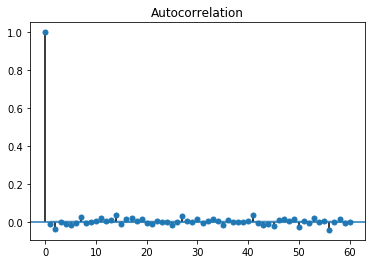

In [42]:
plot_acf(A_ret['op_A_ret'],lags = 60,alpha = 0.5)

It looks like the series is a white noise process because we do not see any non trivial auto correlations beyond lag 0. 

We make test quickly if this observation is accurate using the Dicky-Fuller test on the series A_ret. 

In [43]:
ad_fuller_test(A['op_A'])

The p-value is 0.95256999961


The test implies that A is a random walk. 

We fit ARIMA(p,d,q) models to predict the opening price of the asset A given its previous opening prices. 

We begin by finding the most suitable p,d and q using the AIC and BIC scores. 

In [44]:
ARIMA_fitting_AIC_BIC_list(A['op_A'])

The AIC list is 
[4960.014493545428, 4953.843898623396, 4955.737559571606, 4948.606587814758, 4950.412753975161]
The BIC list is 
[4979.6808492560285, 4980.0657062375294, 4988.5148190892724, 4987.9392992359581, 4996.3009172998936]


The AIC and BIC scores tell us that a ARIMA(2,1,0) is a reasonable choice to make. We compute the MSE of the ARIMA(2,1,0) model as follows and find that on average the model has an error of 0.2024 using a Rolling forecast. 

Rolling forecast error calculation :

In [45]:
testA,predictions_A210 = ARIMA_rolling_forecast(A['op_A'],2,1,0)

/Users/Welliareetil/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


We see in the graph below that the predictions follow the test data almost perfectly. 

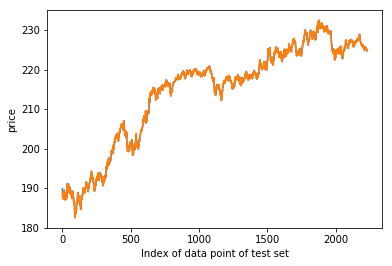

In [50]:
plot_predictions(testA,predictions_A210)

In [47]:
MSE(testA,predictions_A210)

0.202857272149


We calculate the mean absolute scaled error so as to be able to compare the models for the different series. 

In [48]:
MASE(testA,predictions_A210)

The mean absolute scaled error is 0.115669239301


We also test an ARIMA(5,1,0) model.

In [51]:
testA,predictions_A510 = ARIMA_rolling_forecast(A['op_A'],5,1,0)  

/Users/Welliareetil/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [54]:
MSE(testA,predictions_A510)

0.203271100825


In [55]:
MASE(testA,predictions_A510)

The mean absolute scaled error is 0.11575193168


# We predict the opening price of asset B

In [56]:
B_ret.describe()

,op_B,hi_B,lo_B,se_B,volume_B,oi_B,cl_B
count,8957.000000,8957.000000,8957.000000,8957.000000,8957.000000,8957.000000,8957.000000
mean,0.000189,0.000186,0.000187,0.000187,inf,0.020019,0.000188
std,0.004552,0.004039,0.003997,0.004231,NaN,1.625826,0.004550
min,-0.030137,-0.022499,-0.025499,-0.024001,-1.000000,-0.992675,-0.030137
25%,-0.002288,-0.001830,-0.001829,-0.002102,-0.225134,-0.010818,-0.002288
50%,0.000127,0.000118,0.000276,0.000150,0.004957,0.001439,0.000126
75%,0.002670,0.002216,0.002230,0.002513,0.303968,0.014950,0.002668
max,0.044639,0.035004,0.042678,0.036305,inf,153.604520,0.044639


In [57]:
add_ret(B_ret)

We plot the ACF for the returns series of B which is stationary. 

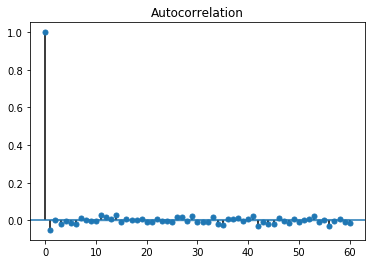

In [58]:
plot_acf(B_ret['op_B_ret'],lags = 60,alpha = 0.5)

In [59]:
ad_fuller_test(B['op_B'])

The p-value is 0.962914807573


It is extremely likely that B is a random walk.

In [60]:
ARIMA_fitting_AIC_BIC_list(B['op_B'])

The AIC list is 
[16815.765743433352, 16817.41412391165, 16813.466413239144, 16815.012563148564, 16816.123094492246]
The BIC list is 
[16835.995859827173, 16844.387612436745, 16847.183273895513, 16855.47279593621, 16863.326699411165]


Selection in this case is slightly more difficult. We choose the ARIMA(1,1,0) model. We will also test the ARIMA(4,1,0) model and the ARIMA(2,1,0) model. 

In [61]:
testB,predictions_B110 = ARIMA_rolling_forecast(B['op_B'],1,1,0)

/Users/Welliareetil/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Welliareetil/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Welliareetil/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Welliareetil/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


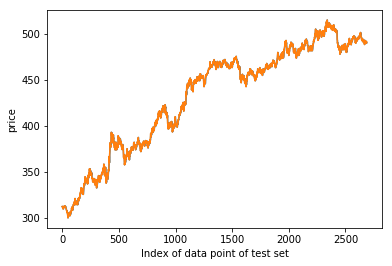

In [65]:
plot_predictions(testB,predictions_B110)

In [63]:
errorB110 = mean_squared_error(testB,predictions_B110)
print(errorB110)

2.68469583124


In [64]:
MASE(testB,predictions_B110)

The mean absolute scaled error is 1.5472763319


We see that the mean absolute scaled error in this case indicates that the model performs WORSE than 
a model which predicts tomorrows opening price as todays price. To be sure we employ an ARIMA(2,1,0) model as well. 

In [66]:
testB,predictions_B210 = ARIMA_rolling_forecast(B['op_B'],2,1,0)

/Users/Welliareetil/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Welliareetil/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


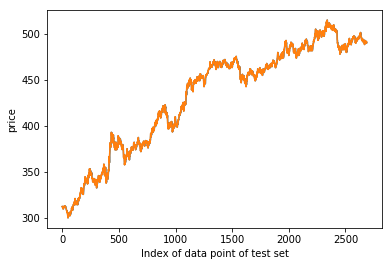

In [67]:
plot_predictions(testB,predictions_B210)

 We calculate the MSE below.

In [69]:
errorB210 = mean_squared_error(testB,predictions_B210)
print(errorB210)

2.6832802102


In [71]:
MASE(testB,predictions_B210)

The mean absolute scaled error is 1.54671884084


# VAR models for asset B

To reduce the scaled error, we look to fit VAR models for the asset B. 

In [73]:
#CCF(B_ret['op_B_ret'],B_ret['hi_B_ret'],'op_B_ret vs hi_B_ret')
#CCF(B_ret['op_B_ret'],B_ret['lo_B_ret'],'op_B_ret vs lo_B_ret')

Looking at the summary statistics above, we see that the feature volume_B_ret has some issues.

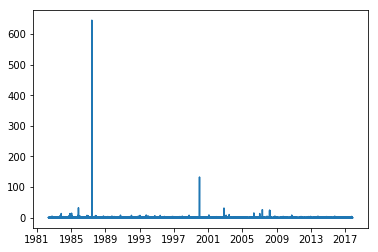

In [74]:
plt.plot(B_ret['volume_B_ret'])      
plt.show()

We observe certain anomalies in the volume data and try to identify the precise points at which these anomalies occurred. 

In [75]:
s = []
for j in range(len(B_ret)):
    if B_ret['volume_B_ret'][j] > 50:
        s.append(j)
print(s) 
strange_dates_B = []
for j in s:
    strange_dates_B.append(B['date'][j])

[798, 1285, 3319, 4157, 4454, 4828]


There are two days which had significant volume changes - 05/06/1985 - 645%, 28/06/2001 - 132%. We consider these extreme outliers and hence alter the information here by replace the values with the mean of the volume changes of the days before and after. 

In [76]:
B_clean = B.copy()

In [77]:
for j in s:
    insert_mean(B_clean['volume_B'],j)

/Users/Welliareetil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [78]:
B_clean_ret = B_clean.copy()
del(B_clean_ret['date'])
B_clean_ret = B_clean_ret.pct_change()
#delete first row of cleaned returns dataframe. 
B_clean_ret = B_clean_ret.dropna()
B_clean_ret.describe()

,op_B,hi_B,lo_B,se_B,volume_B,oi_B,cl_B
count,8957.000000,8957.000000,8957.000000,8957.000000,8957.000000,8957.000000,8957.000000
mean,0.000189,0.000186,0.000187,0.000187,0.144126,0.020019,0.000188
std,0.004552,0.004039,0.003997,0.004231,0.985401,1.625826,0.004550
min,-0.030137,-0.022499,-0.025499,-0.024001,-0.995715,-0.992675,-0.030137
25%,-0.002288,-0.001830,-0.001829,-0.002102,-0.224580,-0.010818,-0.002288
50%,0.000127,0.000118,0.000276,0.000150,0.005415,0.001439,0.000126
75%,0.002670,0.002216,0.002230,0.002513,0.302769,0.014950,0.002668
max,0.044639,0.035004,0.042678,0.036305,32.110540,153.604520,0.044639


In [79]:
#rename the columns of B_clean_ret
add_ret(B_clean_ret)

In [80]:
B_clean_ret.head()

,op_B_ret,hi_B_ret,lo_B_ret,se_B_ret,volume_B_ret,oi_B_ret,cl_B_ret
date,,,,,,,
1982-05-05,0.011853,0.004344,0.009670,0.001741,0.233079,0.181867,0.006941
1982-05-06,0.006941,0.010381,0.009142,0.014335,-0.332529,-0.126201,0.009910
1982-05-07,0.009910,0.004281,0.005608,0.003854,-0.305745,0.003491,-0.002560
1982-05-10,-0.002560,0.000426,0.001716,-0.001706,-0.351364,-0.003479,-0.002139
1982-05-11,-0.002139,0.000426,-0.001713,0.001709,0.261280,-0.050703,0.004286


In [ ]:
#B_clean_ret = closing_price_column(B_clean_ret,'op_B_ret','cl_B_ret')

In [ ]:
#B = closing_price_column(B,'op_B','cl_B')

We begin by selecting a suitable model for prediction. We do so by selecting according to the BIC score. 

In [81]:
selecting_model(B_clean_ret,['cl_B_ret','hi_B_ret', 'lo_B_ret', 'se_B_ret', 'volume_B_ret', 'oi_B_ret'])

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -44.54       -44.53    4.554e-20       -44.53
1        -46.55       -46.51    6.065e-21       -46.54
2        -46.98       -46.90    3.933e-21       -46.96
3        -47.21       -47.09    3.145e-21       -47.17
4        -47.33       -47.16    2.796e-21       -47.27
5        -47.41       -47.21    2.562e-21       -47.34
6        -47.48       -47.24    2.387e-21       -47.40
7        -47.53       -47.25    2.278e-21       -47.43
8        -47.57      -47.25*    2.188e-21       -47.46
9        -47.60       -47.24    2.132e-21       -47.47
10       -47.62       -47.22    2.091e-21       -47.48
11       -47.63       -47.20    2.062e-21       -47.48
12       -47.64       -47.17    2.036e-21       -47.48
13       -47.66       -47.15    1.997e-21      -47.49*
14       -47.67       -47.12    1.974e-21       -47.48
15       -

{'aic': 18, 'bic': 8, 'fpe': 18, 'hqic': 13}

We now write a function that tests the model using a rolling forecast for the given data. 

** Make sure the date columns has already been removed.

** Make sure the first element of the list l is the column 'cl_B_ret'

In [82]:
l = ['cl_B_ret','hi_B_ret', 'lo_B_ret', 'se_B_ret', 'volume_B_ret', 'oi_B_ret']
testB, predictions_BVAR8 = VAR_rolling_forecast(B_clean_ret,l,8)

In [83]:
MASE(testB,predictions_BVAR8)

The mean absolute scaled error is 1.29451065465e-05


We observe a massive improvement in MASE

In [84]:
mean_squared_error(testB,predictions_BVAR8)

1.6075044568510769e-05

We recover the predictions for the closing price of asset B

In [90]:
size = int(len(B_clean_ret)*0.70)
testB_adj,predictions_BVAR8_adj = recover_asset_B_predictions(B['cl_B'],size,testB,predictions_BVAR8)

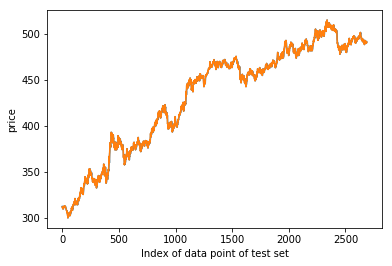

In [91]:
plot_predictions(testB_adj,predictions_BVAR8_adj)

# We predict the opening price of asset C

In [92]:
C_ret.describe()

,op_C,hi_C,lo_C,se_C,volume_C,oi_C,cl_C
count,6822.000000,6822.000000,6822.000000,6822.000000,6822.000000,6822.000000,6822.000000
mean,0.000058,0.000058,0.000058,0.000058,0.274278,0.002201,0.000059
std,0.001083,0.001025,0.000985,0.001021,1.521008,0.051717,0.001083
min,-0.007143,-0.007571,-0.009263,-0.009231,-0.984305,-0.315962,-0.007143
25%,-0.000461,-0.000383,-0.000385,-0.000430,-0.290468,-0.009697,-0.000461
50%,0.000000,0.000000,0.000000,0.000000,-0.000942,0.001623,0.000000
75%,0.000587,0.000478,0.000502,0.000546,0.406833,0.014493,0.000587
max,0.007069,0.009767,0.007599,0.008664,56.071429,0.489942,0.007069


In [94]:
add_ret(C_ret)

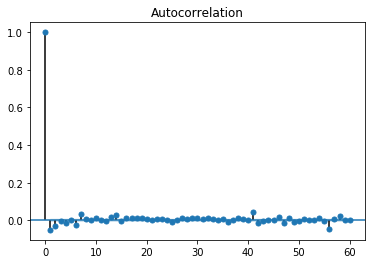

In [95]:
plot_acf(C_ret['op_C_ret'],lags = 60,alpha = 0.5)

In [97]:
ad_fuller_test(C['op_C'])

The p-value is 0.493232730647


We see that the p-value indicates that there is a high chance that C is a random walk. 

In [98]:
ARIMA_fitting_AIC_BIC_list(C['op_C'])

The AIC list is 
[-4503.827592841331, -4507.7979488948695, -4506.2245057312175, -4507.27249312184, -4505.339098590113]
The BIC list is 
[-4484.4141450825873, -4481.9133518832105, -4473.8687594666435, -4468.445597604351, -4460.0410538197093]


In [99]:
testC,predictions_C210 = ARIMA_rolling_forecast(C['op_C'],2,1,0)

/Users/Welliareetil/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


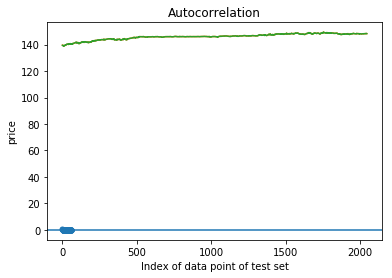

In [100]:
plot_predictions(testC,predictions_C210)

In [101]:
errorC210 = mean_squared_error(testC,predictions_C210)
print(errorC210)

0.00656176273054


In [102]:
MASE(testC,predictions_C210)

The mean absolute scaled error is 0.00338127179786


# We predict the opening price of asset D

In [186]:
D.isnull().sum()

date        0
op_D        0
hi_D        0
lo_D        0
se_D        0
volume_D    0
oi_D        0
cl_D        0
dtype: int64

In [187]:
D = D.fillna(D.mean())

In [188]:
mean_volume_D = D['volume_D'].mean()
D['volume_D']= D.volume_D.mask(D.volume_D == 0,mean_volume_D)
mean_oi_D = D['oi_D'].mean()
D['oi_D']= D.oi_D.mask(D.oi_D == 0,mean_oi_D)

In [189]:
"""Since we have changed the dataframe D, we redefine D_ret"""
D_ret = D.copy()
del(D_ret['date'])
D_ret = D_ret.pct_change()
D_ret = D_ret.dropna(axis = 0)

In [190]:
add_ret(D_ret)

In [191]:
D_ret.describe()

,op_D_ret,hi_D_ret,lo_D_ret,se_D_ret,volume_D_ret,oi_D_ret,cl_D_ret
count,10024.000000,10024.000000,10024.000000,10024.000000,10024.000000,10024.000000,10024.000000
mean,0.000173,0.000166,0.000165,0.000169,23.363956,0.004048,0.000173
std,0.007566,0.006482,0.006487,0.007047,2252.308814,0.147295,0.007566
min,-0.059296,-0.047258,-0.040884,-0.032905,-0.999998,-0.930381,-0.059296
25%,-0.003911,-0.003042,-0.003031,-0.003646,-0.222217,-0.012464,-0.003911
50%,0.000277,0.000000,0.000277,0.000273,0.003471,0.000871,0.000277
75%,0.004269,0.003420,0.003440,0.004084,0.297636,0.016027,0.004269
max,0.059129,0.053608,0.049610,0.040624,225446.000000,11.905247,0.059129


We observe that the feature 'volume_D_ret' has some issues with it, in that the standard deviation is extremely 
large compared to the mean. 

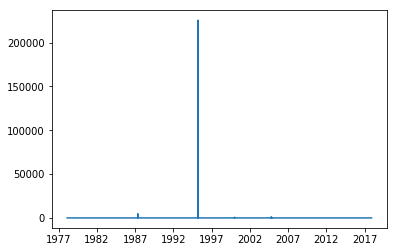

In [192]:
plt.plot(D_ret['volume_D_ret'])
plt.show()

In [193]:
outliers = []
for j in range(len(D_ret)):
    if D_ret['volume_D_ret'][j] > 100:
        outliers.append(j)
print(outliers)        

[2328, 4315, 5516, 6716, 6739]


In [194]:
for j in outliers:
    D_ret['volume_D_ret'][j] = D_ret['volume_D_ret'].mean()

In [195]:
D_ret.describe()

,op_D_ret,hi_D_ret,lo_D_ret,se_D_ret,volume_D_ret,oi_D_ret,cl_D_ret
count,10024.000000,10024.000000,10024.000000,10024.000000,10024.000000,10024.000000,10024.000000
mean,0.000173,0.000166,0.000165,0.000169,0.153686,0.004048,0.000173
std,0.007566,0.006482,0.006487,0.007047,1.140311,0.147295,0.007566
min,-0.059296,-0.047258,-0.040884,-0.032905,-0.999998,-0.930381,-0.059296
25%,-0.003911,-0.003042,-0.003031,-0.003646,-0.222217,-0.012464,-0.003911
50%,0.000277,0.000000,0.000277,0.000273,0.003471,0.000871,0.000277
75%,0.004269,0.003420,0.003440,0.004084,0.297586,0.016027,0.004269
max,0.059129,0.053608,0.049610,0.040624,52.438596,11.905247,0.059129


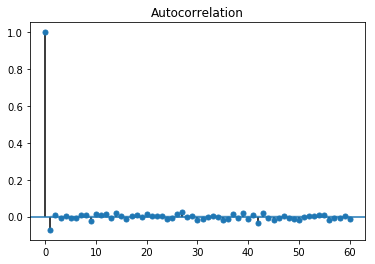

In [196]:
plot_acf(D_ret['op_D_ret'],lags = 60,alpha = 0.5)

In [197]:
ARIMA_fitting_AIC_BIC_list(D['op_D'])

The AIC list is 
[19568.046089126517, 19569.72591228275, 19570.395459004045, 19572.08550001464, 19574.076109728492]
The BIC list is 
[19588.613934728673, 19597.149706418957, 19604.675201674305, 19613.221191218952, 19622.067749466856]


In [198]:
testD, predictions_D110 = ARIMA_rolling_forecast(D['op_D'],1,1,0)

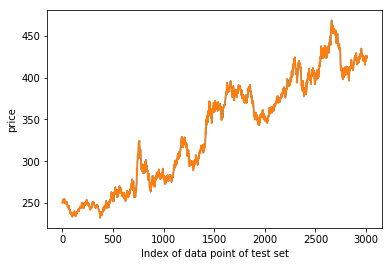

In [202]:
plot_predictions(testD,predictions_D110)

In [203]:
MSE(testD,predictions_D110)

5.05740953847


In [204]:
MASE(testD,predictions_D110)

The mean absolute scaled error is 2.83227648473


In [122]:
D_ret.isnull().sum()

op_D_ret        0
hi_D_ret        0
lo_D_ret        0
se_D_ret        0
volume_D_ret    0
oi_D_ret        0
cl_D_ret        0
dtype: int64

In [ ]:
residuals = pd.DataFrame(mod.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [ ]:
y_pred = mod.forecast(steps = 100)
y_pred[0]

In [ ]:
plt.plot(y_pred[0])
plt.show()

In [ ]:
W = set(C[a:b]['date'])
X = set(A[a:b]['date'])
Y = set(B[a:b]['date'])
Z = set(D[a:b]['date'])
print(Z-X)

In [ ]:
B.describe()